# Options Implied Volatility Analysis

## Purpose

This notebook explores options data via `yfinance` for a set of large-cap "on sale" tickers to analyze implied volatility (IV) patterns.

## Tickers

```python
TICKERS = ["NOW", "ORCL", "BABA", "AVGO", "CRM", "TSM", "NKE", "ADBE"]
```

## What is "ATM IV" (At-The-Money Implied Volatility)?

**ATM Implied Volatility** is the implied volatility of options with strike prices closest to the current stock price (spot). It represents:

- The market's expectation of future price movement
- Higher ATM IV → market expects larger price swings
- Lower ATM IV → market expects price stability

We compute ATM IV as:

```
ATM_IV = average(call_IV_at_ATM_strike, put_IV_at_ATM_strike)
```

This analysis will:

1. Pull current stock prices and option chains for ~30 DTE and ~50 DTE expirations
2. Compute ATM IV for each ticker at both timeframes
3. Rank tickers by ATM IV to identify those with highest expected volatility
4. Visualize IV smiles and term structures
5. Optionally analyze covered call premium yields

---

**Disclaimer**: yfinance uses Yahoo's public endpoints for educational/research purposes. Data may not be institutional-grade accurate.


In [ ]:
import time
import warnings
from datetime import datetime

import stock_screener as ss
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from yfinance import EquityQuery

warnings.filterwarnings("ignore")


def screen_for_candidates(
    max_price: float = 300.0,
    min_market_cap: float = 2_000_000_000,
    min_roe: float = 0.12,
    min_rev_growth: float = 0.05,
    max_pe: float = 40.0,
    max_ps: float = 10.0,
    min_beta: float = 1.0,
    min_inst_held: float = 0.40,
    size: int = 50,
    sort_by: str = "eodvolume",
) -> list[str]:
    # Build the query using EquityQuery
    q = EquityQuery(
        "and",
        [
            # Universe: US stocks on major exchanges
            EquityQuery("eq", ["region", "us"]),
            EquityQuery("is-in", ["exchange", "NMS", "NYQ"]),
            EquityQuery(
                "btwn", ["intradaymarketcap", min_market_cap, 4_000_000_000_000]
            ),
            EquityQuery("btwn", ["intradayprice", 10, max_price]),
            # "On sale" valuation proxies
            EquityQuery("btwn", ["peratio.lasttwelvemonths", 0, max_pe]),
            EquityQuery(
                "lt", ["lastclosemarketcaptotalrevenue.lasttwelvemonths", max_ps]
            ),
            # "Wide moat" quality proxies
            EquityQuery("gte", ["returnontotalcapital.lasttwelvemonths", min_roe]),
            EquityQuery("gte", ["returnonequity.lasttwelvemonths", min_roe]),
            EquityQuery(
                "gte", ["totalrevenues1yrgrowth.lasttwelvemonths", min_rev_growth]
            ),
            EquityQuery("gte", ["pctheldinst", min_inst_held]),
            # Volatility proxy (beta)
            EquityQuery("gte", ["beta", min_beta]),
        ],
    )
    resp = yf.screen(q, size=size, sortField=sort_by, sortAsc=False)
    quotes = []
    if resp:
        # yfinance 1.1.0+ returns quotes at top level
        if "quotes" in resp:
            quotes = resp.get("quotes", [])
        # Older format nested under finance.result
        elif "finance" in resp:
            result = resp.get("finance", {}).get("result", [])
            if result and len(result) > 0:
                quotes = result[0].get("quotes", [])
    tickers = [row.get("symbol") for row in quotes if row.get("symbol")]
    return tickers


# Configuration
TICKERS = screen_for_candidates()
TARGET_DTES = [30, 50, 70]  # Days to expiration targets
MAX_TERM_DTE = 180  # Maximum DTE for term structure analysis
RATE_LIMIT_SLEEP = 0.3  # Seconds between API calls
STRIKE_RANGE_PCT = 0.20  # Show strikes within ±20% of spot

# Cache and output directories

# Date for cache key
TODAY = datetime.now().strftime("%Y-%m-%d")

print("Configuration loaded:")
print(f"  Tickers: {TICKERS}")
print(f"  Target DTEs: {TARGET_DTES}")
print(f"  Max Term DTE: {MAX_TERM_DTE}")
print(f"  Today: {TODAY}")

Configuration loaded:
  Tickers: ['AAPL', 'F', 'CDE', 'AMZN', 'NFLX', 'FCX', 'ORCL', 'PATH', 'KGC', 'UBER', 'SMCI', 'CCL', 'WDC', 'PAAS', 'PYPL', 'UMC', 'NCLH', 'HST', 'IAG', 'MRVL', 'CRM', 'SM', 'CARR', 'DECK', 'COIN', 'QCOM', 'ASX', 'CNQ', 'AA', 'HBM', 'GAP', 'XP', 'WT', 'GM', 'FTNT', 'UGI', 'KIM', 'GEN', 'XYZ', 'DAL', 'TECK', 'CPRT', 'ADBE', 'UAL', 'ACN', 'SW', 'PAGS', 'DOCU', 'CRH', 'MMM']
  Target DTEs: [30, 50, 70]
  Max Term DTE: 180
  Today: 2026-02-02


In [9]:
def get_spot(ticker: str) -> float | None:
    try:
        t = yf.Ticker(ticker)

        # Try history first (more reliable)
        hist = t.history(period="1d")
        if not hist.empty and "Close" in hist.columns:
            return float(hist["Close"].iloc[-1])

        # Fallback to fast_info
        if hasattr(t, "fast_info") and t.fast_info:
            price = t.fast_info.get("lastPrice") or t.fast_info.get(
                "regularMarketPrice"
            )
            if price:
                return float(price)

        # Last resort: info dict
        info = t.info
        if info:
            price = info.get("regularMarketPrice") or info.get("currentPrice")
            if price:
                return float(price)

        print(f"  ⚠️ Could not get spot price for {ticker}")
        return None

    except Exception as e:
        print(f"  ⚠️ Error getting spot for {ticker}: {e}")
        return None


test_spot = get_spot("AAPL")
print(f"AAPL spot: ${test_spot:.2f}" if test_spot else "  AAPL spot: unavailable")

AAPL spot: $270.01


In [10]:
def get_expirations(ticker: str) -> list[tuple[str, int]]:
    try:
        t = yf.Ticker(ticker)
        exp_dates = t.options

        if not exp_dates:
            print(f"  ⚠️ No expirations found for {ticker}")
            return []

        today = datetime.now().date()
        result = []

        for exp_str in exp_dates:
            try:
                exp_date = datetime.strptime(exp_str, "%Y-%m-%d").date()
                dte = (exp_date - today).days
                if dte > 0:  # Only future expirations
                    result.append((exp_str, dte))
            except ValueError:
                continue

        return sorted(result, key=lambda x: x[1])

    except Exception as e:
        print(f"  ⚠️ Error getting expirations for {ticker}: {e}")
        return []


test_exps = get_expirations("AAPL")
if test_exps:
    print(f"Found {len(test_exps)} expirations")
    print(f"Nearest 5: {test_exps[:5]}")

Found 24 expirations
Nearest 5: [('2026-02-04', 2), ('2026-02-06', 4), ('2026-02-09', 7), ('2026-02-11', 9), ('2026-02-13', 11)]


In [11]:
def pick_expiration(
    expirations: list[tuple[str, int]], target_dte: int
) -> tuple[str, int] | None:
    if not expirations:
        return None

    # Find expiration with minimum distance to target
    best = min(expirations, key=lambda x: abs(x[1] - target_dte))
    return best


# Test the function
if test_exps:
    for target in [30, 50, 70]:
        picked = pick_expiration(test_exps, target)
        if picked:
            print(f"Target {target} DTE -> picked {picked[0]} (actual {picked[1]} DTE)")

Target 30 DTE -> picked 2026-03-06 (actual 32 DTE)
Target 50 DTE -> picked 2026-03-20 (actual 46 DTE)
Target 70 DTE -> picked 2026-04-17 (actual 74 DTE)


In [12]:
def fetch_chain(
    ticker: str, exp_date_str: str, spot: float
) -> tuple[pd.DataFrame, pd.DataFrame]:
    try:
        t = yf.Ticker(ticker)
        chain = t.option_chain(exp_date_str)

        calls = chain.calls.copy()
        puts = chain.puts.copy()

        if calls.empty and puts.empty:
            print(f"    ⚠️ Empty chain for {ticker} @ {exp_date_str}")
            return pd.DataFrame(), pd.DataFrame()

        # Calculate DTE
        exp_date = datetime.strptime(exp_date_str, "%Y-%m-%d").date()
        dte = (exp_date - datetime.now().date()).days

        # Enrich calls
        if not calls.empty:
            calls["ticker"] = ticker
            calls["expiration"] = exp_date_str
            calls["dte"] = dte
            calls["spot"] = spot
            calls["optionType"] = "C"
            calls["mid"] = (calls["bid"] + calls["ask"]) / 2
            calls["moneyness"] = calls["strike"] / spot

        # Enrich puts
        if not puts.empty:
            puts["ticker"] = ticker
            puts["expiration"] = exp_date_str
            puts["dte"] = dte
            puts["spot"] = spot
            puts["optionType"] = "P"
            puts["mid"] = (puts["bid"] + puts["ask"]) / 2
            puts["moneyness"] = puts["strike"] / spot

        return calls, puts

    except Exception as e:
        print(f"    ⚠️ Error fetching chain for {ticker} @ {exp_date_str}: {e}")
        return pd.DataFrame(), pd.DataFrame()


if test_spot and test_exps:
    test_calls, test_puts = fetch_chain("AAPL", test_exps[0][0], test_spot)
    print(f"Calls: {len(test_calls)} rows, Puts: {len(test_puts)} rows")
    if not test_calls.empty:
        print(f"Call columns: {', '.join(list(test_calls.columns))}")

Calls: 36 rows, Puts: 29 rows
Call columns: contractSymbol, lastTradeDate, strike, lastPrice, bid, ask, change, percentChange, volume, openInterest, impliedVolatility, inTheMoney, contractSize, currency, ticker, expiration, dte, spot, optionType, mid, moneyness


In [13]:
def compute_atm_iv(
    calls: pd.DataFrame, puts: pd.DataFrame, spot: float
) -> float | None:
    if calls.empty and puts.empty:
        return None

    atm_ivs = []

    # Get ATM call IV
    if not calls.empty and "impliedVolatility" in calls.columns:
        calls_valid = calls[
            calls["impliedVolatility"].notna() & (calls["impliedVolatility"] > 0)
        ]
        if not calls_valid.empty:
            atm_call_idx = (calls_valid["strike"] - spot).abs().idxmin()
            atm_call_iv = calls_valid.loc[atm_call_idx, "impliedVolatility"]
            atm_ivs.append(atm_call_iv)

    # Get ATM put IV
    if not puts.empty and "impliedVolatility" in puts.columns:
        puts_valid = puts[
            puts["impliedVolatility"].notna() & (puts["impliedVolatility"] > 0)
        ]
        if not puts_valid.empty:
            atm_put_idx = (puts_valid["strike"] - spot).abs().idxmin()
            atm_put_iv = puts_valid.loc[atm_put_idx, "impliedVolatility"]
            atm_ivs.append(atm_put_iv)

    if atm_ivs:
        return np.mean(atm_ivs)
    return None


if test_spot and not test_calls.empty:
    test_atm_iv = compute_atm_iv(test_calls, test_puts, test_spot)
    if test_atm_iv:
        print(f" AAPL ATM IV: {test_atm_iv:.2%}")

 AAPL ATM IV: 26.66%


## Main Analysis Loop

Now we'll loop over all tickers to:

1. Get spot price
2. Get available expirations
3. Pick expirations closest to 30 DTE and 50 DTE
4. Fetch option chains and compute ATM IV
5. Build term structure data (ATM IV across all expirations up to MAX_TERM_DTE)


In [14]:
summary_data = []
term_structure_data = []
chains_50dte = {}  # Store 50 DTE chains for IV smile plots

print("=" * 60)
print("ANALYZING OPTIONS DATA FOR TICKERS")
print("=" * 60)

for ticker in TICKERS:
    print(f"\n📊 Processing {ticker}...")

    # Get spot price
    spot = get_spot(ticker)
    if spot is None:
        print(f"  ❌ Skipping {ticker} - no spot price")
        continue
    print(f"  Spot: ${spot:.2f}")

    # Get expirations
    time.sleep(RATE_LIMIT_SLEEP)
    expirations = get_expirations(ticker)
    if not expirations:
        print(f"  ❌ Skipping {ticker} - no expirations")
        continue
    print(f"  Found {len(expirations)} expirations")

    # Initialize summary row
    row = {
        "ticker": ticker,
        "spot": spot,
        "exp_30dte": None,
        "actual_dte_30": None,
        "atm_iv_30": None,
        "exp_50dte": None,
        "actual_dte_50": None,
        "atm_iv_50": None,
    }

    # Process target DTEs
    for target_dte in TARGET_DTES:
        picked = pick_expiration(expirations, target_dte)
        if not picked:
            continue

        exp_date, actual_dte = picked
        print(f"  Target {target_dte} DTE → {exp_date} (actual {actual_dte} DTE)")

        # Fetch chain
        time.sleep(RATE_LIMIT_SLEEP)
        calls, puts = fetch_chain(ticker, exp_date, spot)

        if calls.empty and puts.empty:
            continue

        # Compute ATM IV
        atm_iv = compute_atm_iv(calls, puts, spot)
        if atm_iv:
            print(f"    ATM IV: {atm_iv:.2%}")

        # Store in row
        if target_dte == 30:
            row["exp_30dte"] = exp_date
            row["actual_dte_30"] = actual_dte
            row["atm_iv_30"] = atm_iv
        elif target_dte == 50:
            row["exp_50dte"] = exp_date
            row["actual_dte_50"] = actual_dte
            row["atm_iv_50"] = atm_iv
            # Store chain for IV smile plot
            chains_50dte[ticker] = {
                "calls": calls,
                "puts": puts,
                "spot": spot,
                "exp": exp_date,
            }

    summary_data.append(row)

    # Build term structure: ATM IV across all expirations up to MAX_TERM_DTE
    print(f"  Building term structure (up to {MAX_TERM_DTE} DTE)...")
    term_exps = [e for e in expirations if e[1] <= MAX_TERM_DTE]

    for exp_date, dte in term_exps:
        time.sleep(RATE_LIMIT_SLEEP * 0.5)  # Faster for term structure
        calls, puts = fetch_chain(ticker, exp_date, spot)

        if calls.empty and puts.empty:
            continue

        atm_iv = compute_atm_iv(calls, puts, spot)
        if atm_iv:
            term_structure_data.append(
                {"ticker": ticker, "expiration": exp_date, "dte": dte, "atm_iv": atm_iv}
            )

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

ANALYZING OPTIONS DATA FOR TICKERS

📊 Processing AAPL...
  Spot: $270.01
  Found 24 expirations
  Target 30 DTE → 2026-03-06 (actual 32 DTE)
    ATM IV: 26.58%
  Target 50 DTE → 2026-03-20 (actual 46 DTE)
    ATM IV: 24.13%
  Target 70 DTE → 2026-04-17 (actual 74 DTE)
    ATM IV: 23.88%
  Building term structure (up to 180 DTE)...

📊 Processing F...
  Spot: $13.81
  Found 15 expirations
  Target 30 DTE → 2026-03-06 (actual 32 DTE)
    ATM IV: 37.79%
  Target 50 DTE → 2026-03-20 (actual 46 DTE)
    ATM IV: 32.03%
  Target 70 DTE → 2026-04-17 (actual 74 DTE)
    ATM IV: 30.52%
  Building term structure (up to 180 DTE)...

📊 Processing CDE...
  Spot: $20.32
  Found 14 expirations
  Target 30 DTE → 2026-03-06 (actual 32 DTE)
    ATM IV: 94.63%
  Target 50 DTE → 2026-03-20 (actual 46 DTE)
    ATM IV: 90.92%
  Target 70 DTE → 2026-03-20 (actual 46 DTE)
    ATM IV: 90.92%
  Building term structure (up to 180 DTE)...

📊 Processing AMZN...
  Spot: $242.96
  Found 25 expirations
  Target 30 DTE 

## Summary and Ranking Tables

Display the summary table showing spot prices and ATM IV for each ticker, then rank by ATM IV to identify the highest volatility names.


In [15]:
summary_df = pd.DataFrame(summary_data)

if not summary_df.empty:
    # Format for display
    display_df = summary_df.copy()
    display_df["spot"] = display_df["spot"].apply(
        lambda x: f"${x:.2f}" if pd.notna(x) else "N/A"
    )
    display_df["atm_iv_30"] = display_df["atm_iv_30"].apply(
        lambda x: f"{x:.2%}" if pd.notna(x) else "N/A"
    )
    display_df["atm_iv_50"] = display_df["atm_iv_50"].apply(
        lambda x: f"{x:.2%}" if pd.notna(x) else "N/A"
    )

    display_df = display_df.rename(
        columns={
            "ticker": "Ticker",
            "spot": "Spot Price",
            "exp_30dte": "Exp ~30 DTE",
            "actual_dte_30": "DTE",
            "atm_iv_30": "ATM IV ~30",
            "exp_50dte": "Exp ~50 DTE",
            "actual_dte_50": "DTE (50)",
            "atm_iv_50": "ATM IV ~50",
        }
    )

    print("=" * 80)
    print("SUMMARY TABLE: Spot Prices and ATM IV for ~30 DTE and ~50 DTE")
    print("=" * 80)
    print(display_df.to_string(index=False))
else:
    print("No summary data available")

SUMMARY TABLE: Spot Prices and ATM IV for ~30 DTE and ~50 DTE
Ticker Spot Price Exp ~30 DTE  DTE ATM IV ~30 Exp ~50 DTE  DTE (50) ATM IV ~50
  AAPL    $270.01  2026-03-06   32     26.58%  2026-03-20        46     24.13%
     F     $13.81  2026-03-06   32     37.79%  2026-03-20        46     32.03%
   CDE     $20.32  2026-03-06   32     94.63%  2026-03-20        46     90.92%
  AMZN    $242.96  2026-03-06   32     44.10%  2026-03-20        46     38.38%
  NFLX     $82.76  2026-03-06   32     31.15%  2026-03-20        46     32.59%
   FCX     $60.76  2026-03-06   32     51.49%  2026-03-20        46     50.23%
  ORCL    $160.06  2026-03-06   32     55.94%  2026-03-20        46     65.34%
  PATH     $12.54  2026-03-06   32     60.06%  2026-03-20        46     80.52%
   KGC     $31.58  2026-03-06   32     61.43%  2026-03-20        46     60.58%
  UBER     $80.84  2026-03-06   32     48.16%  2026-03-20        46     42.53%
  SMCI     $29.71  2026-03-06   32     81.30%  2026-03-20        46  

In [16]:
def highlight_max(s):
    """Style function to highlight maximum value."""
    is_max = s == s.max()
    return ["background-color: #90EE90; font-weight: bold" if v else "" for v in is_max]


if not summary_df.empty:
    # Ranking by ATM IV ~30 DTE
    print("\n" + "=" * 60)
    print("RANKING BY ATM IV (~30 DTE) - Highest IV First")
    print("=" * 60)

    rank_30 = summary_df[
        ["ticker", "spot", "exp_30dte", "actual_dte_30", "atm_iv_30"]
    ].copy()
    rank_30 = rank_30.dropna(subset=["atm_iv_30"])
    rank_30 = rank_30.sort_values("atm_iv_30", ascending=False).reset_index(drop=True)
    rank_30["rank"] = range(1, len(rank_30) + 1)
    rank_30["atm_iv_30_pct"] = rank_30["atm_iv_30"].apply(lambda x: f"{x:.2%}")
    rank_30["spot"] = rank_30["spot"].apply(lambda x: f"${x:.2f}")

    rank_30_display = rank_30[
        ["rank", "ticker", "spot", "exp_30dte", "actual_dte_30", "atm_iv_30_pct"]
    ]
    rank_30_display.columns = ["Rank", "Ticker", "Spot", "Expiration", "DTE", "ATM IV"]
    print(rank_30_display.to_string(index=False))

    if not rank_30.empty:
        top_iv_30 = rank_30.iloc[0]
        print(
            f"\n🏆 HIGHEST IV (~30 DTE): {top_iv_30['ticker']} at {top_iv_30['atm_iv_30_pct']}"
        )

    # Ranking by ATM IV ~50 DTE
    print("\n" + "=" * 60)
    print("RANKING BY ATM IV (~50 DTE) - Highest IV First")
    print("=" * 60)

    rank_50 = summary_df[
        ["ticker", "spot", "exp_50dte", "actual_dte_50", "atm_iv_50"]
    ].copy()
    rank_50 = rank_50.dropna(subset=["atm_iv_50"])
    rank_50 = rank_50.sort_values("atm_iv_50", ascending=False).reset_index(drop=True)
    rank_50["rank"] = range(1, len(rank_50) + 1)
    rank_50["atm_iv_50_pct"] = rank_50["atm_iv_50"].apply(lambda x: f"{x:.2%}")
    rank_50["spot"] = rank_50["spot"].apply(lambda x: f"${x:.2f}")

    rank_50_display = rank_50[
        ["rank", "ticker", "spot", "exp_50dte", "actual_dte_50", "atm_iv_50_pct"]
    ]
    rank_50_display.columns = ["Rank", "Ticker", "Spot", "Expiration", "DTE", "ATM IV"]
    print(rank_50_display.to_string(index=False))

    if not rank_50.empty:
        top_iv_50 = rank_50.iloc[0]
        print(
            f"\n🏆 HIGHEST IV (~50 DTE): {top_iv_50['ticker']} at {top_iv_50['atm_iv_50_pct']}"
        )


RANKING BY ATM IV (~30 DTE) - Highest IV First
 Rank Ticker    Spot Expiration  DTE ATM IV
    1    CDE  $20.32 2026-03-06   32 94.63%
    2    IAG  $18.19 2026-02-20   18 81.84%
    3    WDC $270.23 2026-03-06   32 81.60%
    4   SMCI  $29.71 2026-03-06   32 81.30%
    5   PAAS  $53.63 2026-03-06   32 75.06%
    6    HBM  $24.10 2026-02-20   18 72.36%
    7     SW  $41.96 2026-02-20   18 70.09%
    8     WT  $16.06 2026-02-20   18 69.73%
    9   COIN $187.86 2026-03-06   32 65.64%
   10   MRVL  $78.66 2026-03-06   32 62.22%
   11    KGC  $31.58 2026-03-06   32 61.43%
   12    GEN  $23.79 2026-02-20   18 60.11%
   13   PATH  $12.54 2026-03-06   32 60.06%
   14    UMC  $10.04 2026-02-20   18 59.08%
   15    XYZ  $60.40 2026-03-06   32 58.91%
   16     AA  $58.21 2026-03-06   32 58.89%
   17   NCLH  $23.64 2026-03-06   32 56.10%
   18   ORCL $160.06 2026-03-06   32 55.94%
   19    GAP  $28.67 2026-03-06   32 55.81%
   20   DOCU  $52.00 2026-03-06   32 54.53%
   21     XP  $19.81 2026-03

## Filtered Option Chain Tables (~50 DTE)

For each ticker, show the option chain around the spot price (strikes within ±20% of spot) for the ~50 DTE expiration. Key columns: strike, bid, ask, volume, openInterest, impliedVolatility.


In [17]:
for ticker, chain_data in chains_50dte.items():
    calls = chain_data["calls"]
    puts = chain_data["puts"]
    spot = chain_data["spot"]
    exp = chain_data["exp"]

    print("\n" + "=" * 80)
    print(f"{ticker} Option Chain (~50 DTE: {exp}) | Spot: ${spot:.2f}")
    print("Strikes within ±20% of spot")
    print("=" * 80)

    # Filter strikes within range
    low_strike = spot * (1 - STRIKE_RANGE_PCT)
    high_strike = spot * (1 + STRIKE_RANGE_PCT)

    # Key columns to display
    display_cols = [
        "strike",
        "bid",
        "ask",
        "volume",
        "openInterest",
        "impliedVolatility",
    ]

    # CALLS
    if not calls.empty:
        calls_filtered = calls[
            (calls["strike"] >= low_strike) & (calls["strike"] <= high_strike)
        ]
        if not calls_filtered.empty:
            print(f"\n📈 CALLS ({len(calls_filtered)} strikes)")
            calls_display = calls_filtered[display_cols].copy()
            calls_display["impliedVolatility"] = calls_display[
                "impliedVolatility"
            ].apply(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
            calls_display = calls_display.rename(
                columns={
                    "strike": "Strike",
                    "bid": "Bid",
                    "ask": "Ask",
                    "volume": "Volume",
                    "openInterest": "OI",
                    "impliedVolatility": "IV",
                }
            )
            print(calls_display.to_string(index=False))

    # PUTS
    if not puts.empty:
        puts_filtered = puts[
            (puts["strike"] >= low_strike) & (puts["strike"] <= high_strike)
        ]
        if not puts_filtered.empty:
            print(f"\n📉 PUTS ({len(puts_filtered)} strikes)")
            puts_display = puts_filtered[display_cols].copy()
            puts_display["impliedVolatility"] = puts_display["impliedVolatility"].apply(
                lambda x: f"{x:.2%}" if pd.notna(x) else "N/A"
            )
            puts_display = puts_display.rename(
                columns={
                    "strike": "Strike",
                    "bid": "Bid",
                    "ask": "Ask",
                    "volume": "Volume",
                    "openInterest": "OI",
                    "impliedVolatility": "IV",
                }
            )
            print(puts_display.to_string(index=False))


AAPL Option Chain (~50 DTE: 2026-03-20) | Spot: $270.01
Strikes within ±20% of spot

📈 CALLS (21 strikes)
 Strike   Bid   Ask  Volume    OI     IV
  220.0 50.50 52.40   296.0  5352 48.44%
  225.0 45.05 48.10     7.0   211 48.19%
  230.0 41.10 42.45   136.0  5891 40.80%
  235.0 36.75 37.30    18.0   679 36.11%
  240.0 32.05 32.55   278.0 10260 33.37%
  245.0 27.65 28.00   160.0  2520 31.24%
  250.0 23.25 23.60  1623.0 14811 29.25%
  255.0 19.15 20.00  2697.0  4672 29.30%
  260.0 14.90 15.65  7483.0 27531 26.24%
  265.0 11.60 12.30  7351.0  6757 25.31%
  270.0  8.80  9.50  5601.0 27528 24.84%
  275.0  6.20  6.80  6266.0 13196 23.52%
  280.0  4.55  4.75  8952.0 60475 22.76%
  285.0  3.15  3.30  4384.0 21513 22.52%
  290.0  2.05  2.10  5389.0 14819 21.86%
  295.0  1.31  1.42   614.0  5967 22.02%
  300.0  0.85  0.96  4331.0 49025 22.29%
  305.0  0.54  0.75   231.0  3529 23.38%
  310.0  0.35  0.45   244.0  7875 23.10%
  315.0  0.23  0.29   125.0  1147 23.24%
  320.0  0.11  0.20   234.0 1080

## IV Smile Visualization (~50 DTE)

Plot the implied volatility smile for each ticker: IV vs Strike for both calls and puts at the ~50 DTE expiration. A vertical line marks the current spot price.


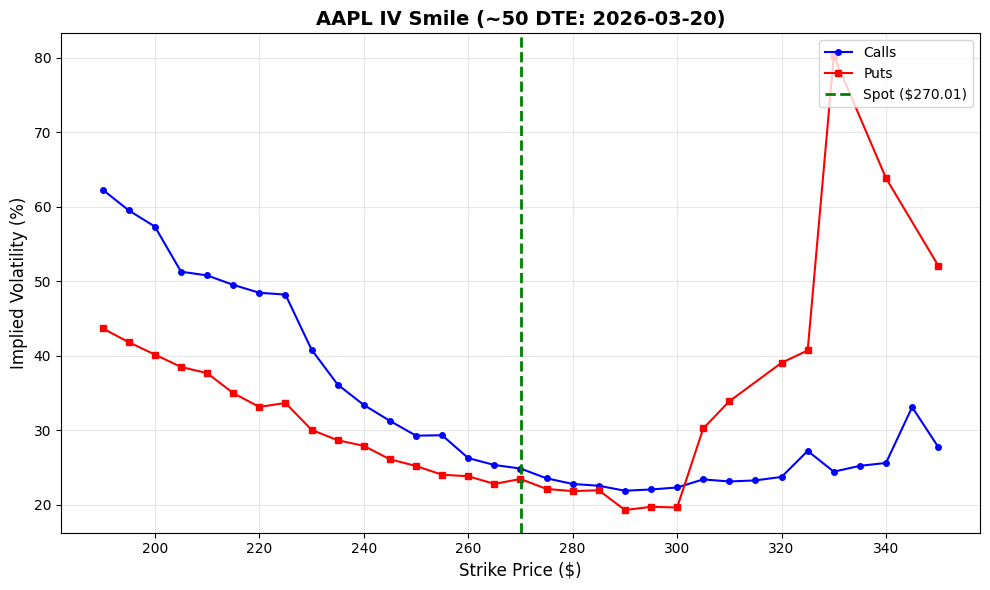

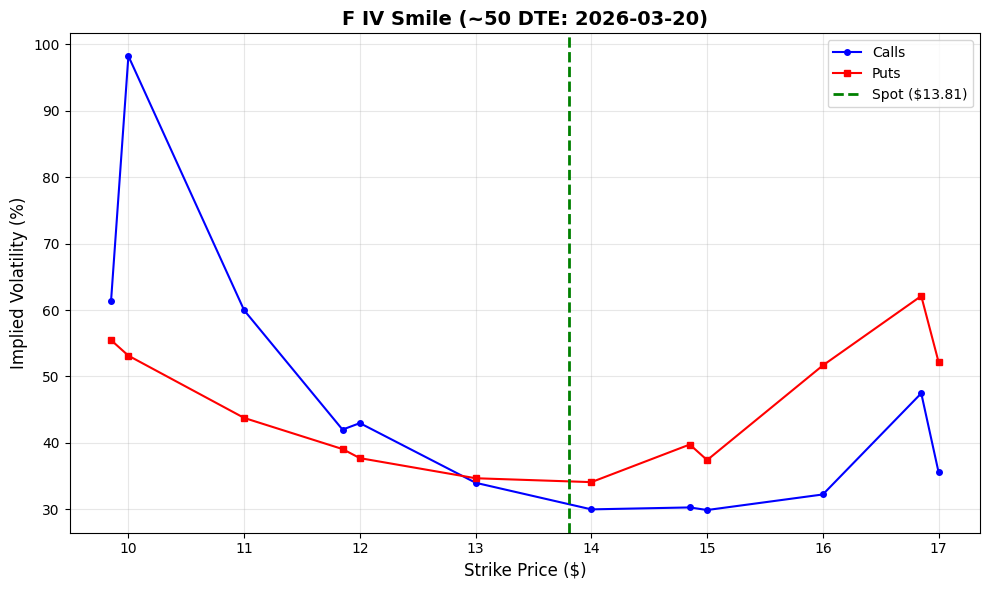

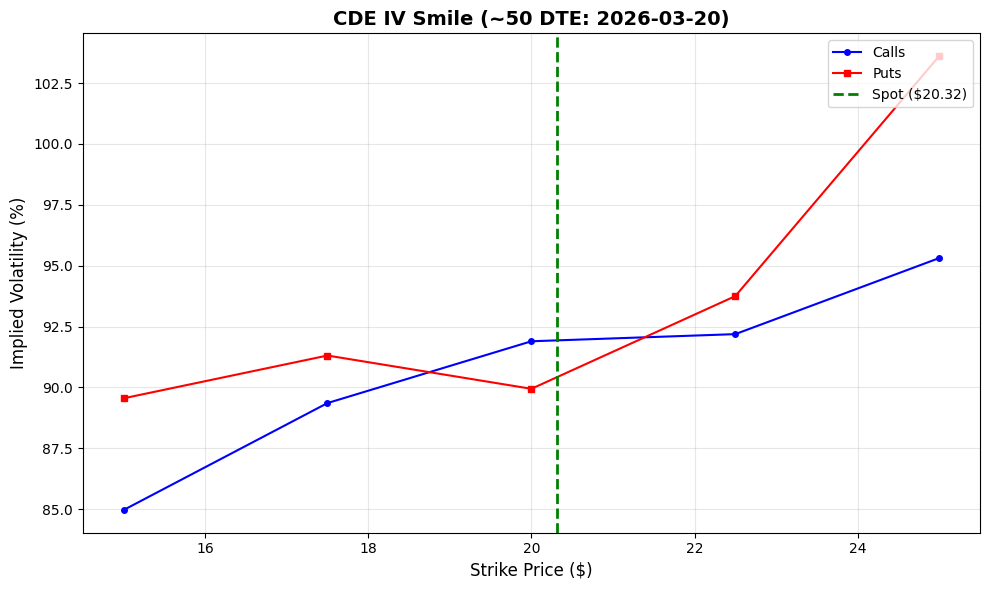

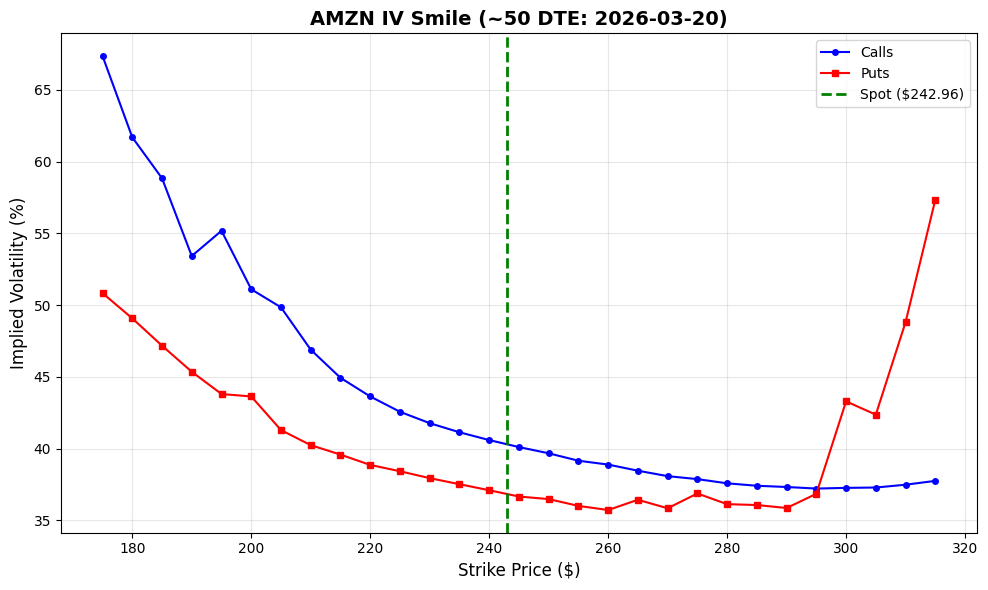

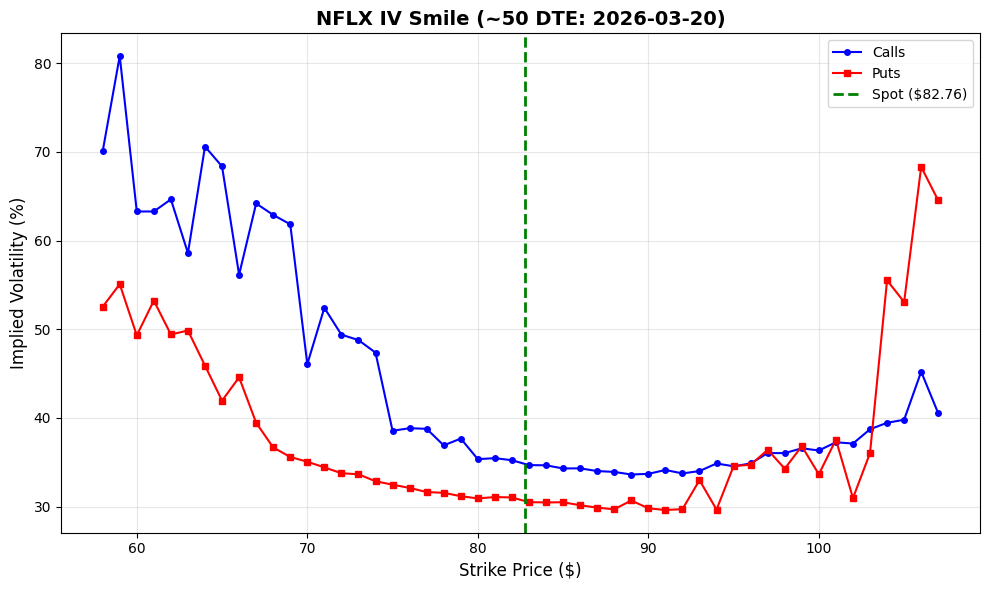

In [18]:
for ticker, chain_data in list(chains_50dte.items())[
    0:5
]:  # Limit to first 5 for brevity
    calls = chain_data["calls"]
    puts = chain_data["puts"]
    spot = chain_data["spot"]
    exp = chain_data["exp"]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Filter to reasonable strike range for cleaner plot
    low_strike = spot * 0.7
    high_strike = spot * 1.3

    # Plot calls
    if not calls.empty and "impliedVolatility" in calls.columns:
        calls_plot = calls[
            (calls["strike"] >= low_strike)
            & (calls["strike"] <= high_strike)
            & (calls["impliedVolatility"].notna())
            & (calls["impliedVolatility"] > 0)
        ]
        if not calls_plot.empty:
            ax.plot(
                calls_plot["strike"],
                calls_plot["impliedVolatility"] * 100,
                "b-o",
                label="Calls",
                markersize=4,
                linewidth=1.5,
            )

    # Plot puts
    if not puts.empty and "impliedVolatility" in puts.columns:
        puts_plot = puts[
            (puts["strike"] >= low_strike)
            & (puts["strike"] <= high_strike)
            & (puts["impliedVolatility"].notna())
            & (puts["impliedVolatility"] > 0)
        ]
        if not puts_plot.empty:
            ax.plot(
                puts_plot["strike"],
                puts_plot["impliedVolatility"] * 100,
                "r-s",
                label="Puts",
                markersize=4,
                linewidth=1.5,
            )

    # Vertical line at spot
    ax.axvline(
        x=spot, color="green", linestyle="--", linewidth=2, label=f"Spot (${spot:.2f})"
    )

    ax.set_xlabel("Strike Price ($)", fontsize=12)
    ax.set_ylabel("Implied Volatility (%)", fontsize=12)
    ax.set_title(f"{ticker} IV Smile (~50 DTE: {exp})", fontsize=14, fontweight="bold")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## IV Term Structure

Plot ATM IV across different expirations (DTE) to visualize the term structure. Each line represents a ticker, showing how implied volatility changes with time to expiration.


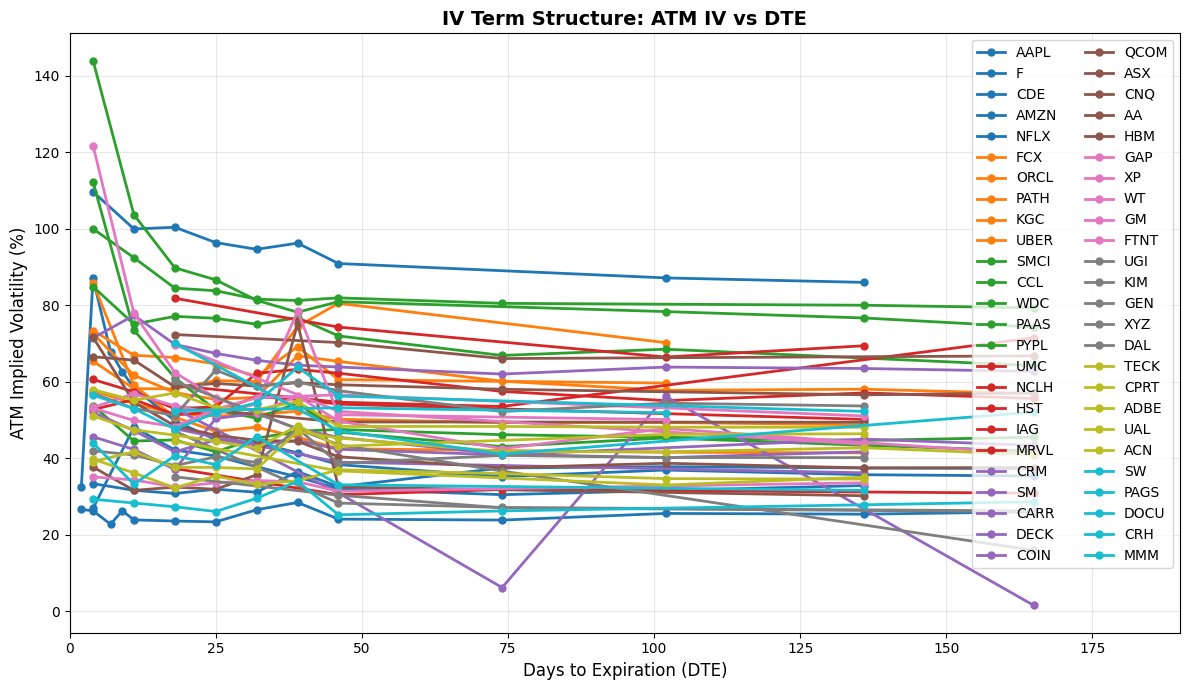

In [19]:
term_df = pd.DataFrame(term_structure_data)

if not term_df.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Define colors for tickers
    colors = plt.cm.tab10(np.linspace(0, 1, len(TICKERS)))
    color_map = dict(zip(TICKERS, colors))

    for ticker in TICKERS:
        ticker_data = term_df[term_df["ticker"] == ticker].sort_values("dte")
        if not ticker_data.empty:
            ax.plot(
                ticker_data["dte"],
                ticker_data["atm_iv"] * 100,
                "-o",
                label=ticker,
                color=color_map.get(ticker),
                markersize=5,
                linewidth=2,
            )

    ax.set_xlabel("Days to Expiration (DTE)", fontsize=12)
    ax.set_ylabel("ATM Implied Volatility (%)", fontsize=12)
    ax.set_title("IV Term Structure: ATM IV vs DTE", fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, MAX_TERM_DTE + 10)

    plt.tight_layout()
    plt.show()
else:
    print("No term structure data available")

## Covered Call Premium Yield Analysis (Optional)

For the ~50 DTE expiration, compute the "premium yield" for covered calls at various OTM strike levels.

**Premium Yield** = Mid Price / Spot Price

This shows the annualized return potential from selling covered calls at different OTM levels (1%, 3%, 5%, 7% above spot).


In [20]:
OTM_LEVELS = [0.01, 0.03, 0.05, 0.07]  # 1%, 3%, 5%, 7% OTM

premium_yield_data = []

for ticker, chain_data in chains_50dte.items():
    calls = chain_data["calls"]
    spot = chain_data["spot"]
    exp = chain_data["exp"]
    dte = chain_data["calls"]["dte"].iloc[0] if not chain_data["calls"].empty else 50

    if calls.empty:
        continue

    for otm_pct in OTM_LEVELS:
        target_strike = spot * (1 + otm_pct)

        # Find strike nearest to target
        calls_valid = calls[calls["mid"].notna() & (calls["mid"] > 0)]
        if calls_valid.empty:
            continue

        idx = (calls_valid["strike"] - target_strike).abs().idxmin()
        row = calls_valid.loc[idx]

        actual_strike = row["strike"]
        mid_price = row["mid"]
        actual_otm = (actual_strike / spot - 1) * 100

        # Premium yield (raw)
        premium_yield = mid_price / spot

        # Annualized yield (simple)
        annualized_yield = premium_yield * (365 / dte) if dte > 0 else 0

        premium_yield_data.append(
            {
                "ticker": ticker,
                "spot": spot,
                "target_otm_pct": f"{otm_pct:.0%}",
                "actual_strike": actual_strike,
                "actual_otm_pct": f"{actual_otm:.1f}%",
                "mid_price": mid_price,
                "premium_yield": premium_yield,
                "annualized_yield": annualized_yield,
                "dte": dte,
            }
        )

# Create and display table
premium_df = pd.DataFrame(premium_yield_data)

if not premium_df.empty:
    print("=" * 100)
    print("COVERED CALL PREMIUM YIELD TABLE (~50 DTE)")
    print("=" * 100)

    # Pivot for cleaner display
    for ticker in premium_df["ticker"].unique():
        ticker_data = premium_df[premium_df["ticker"] == ticker]
        spot = ticker_data["spot"].iloc[0]
        dte = ticker_data["dte"].iloc[0]

        print(f"\n{ticker} | Spot: ${spot:.2f} | DTE: {dte}")
        print("-" * 80)

        display_data = ticker_data[
            [
                "target_otm_pct",
                "actual_strike",
                "actual_otm_pct",
                "mid_price",
                "premium_yield",
                "annualized_yield",
            ]
        ].copy()
        display_data["mid_price"] = display_data["mid_price"].apply(
            lambda x: f"${x:.2f}"
        )
        display_data["premium_yield"] = display_data["premium_yield"].apply(
            lambda x: f"{x:.2%}"
        )
        display_data["annualized_yield"] = display_data["annualized_yield"].apply(
            lambda x: f"{x:.1%}"
        )
        display_data["actual_strike"] = display_data["actual_strike"].apply(
            lambda x: f"${x:.0f}"
        )

        display_data.columns = [
            "Target OTM",
            "Strike",
            "Actual OTM",
            "Mid Price",
            "Yield",
            "Ann. Yield",
        ]
        print(display_data.to_string(index=False))

    # Summary: Best premium yields at each OTM level
    print("\n" + "=" * 80)
    print("BEST PREMIUM YIELDS BY OTM LEVEL")
    print("=" * 80)

    for otm in premium_df["target_otm_pct"].unique():
        otm_data = premium_df[premium_df["target_otm_pct"] == otm]
        best = otm_data.loc[otm_data["premium_yield"].idxmax()]
        print(
            f"  {otm} OTM: {best['ticker']} @ ${best['actual_strike']:.0f} → {best['premium_yield']:.2%} yield ({best['annualized_yield']:.1%} ann.)"
        )
else:
    print("No premium yield data available")

COVERED CALL PREMIUM YIELD TABLE (~50 DTE)

AAPL | Spot: $270.01 | DTE: 46
--------------------------------------------------------------------------------
Target OTM Strike Actual OTM Mid Price Yield Ann. Yield
        1%   $275       1.8%     $6.50 2.41%      19.1%
        3%   $280       3.7%     $4.65 1.72%      13.7%
        5%   $285       5.6%     $3.22 1.19%       9.5%
        7%   $290       7.4%     $2.08 0.77%       6.1%

F | Spot: $13.81 | DTE: 46
--------------------------------------------------------------------------------
Target OTM Strike Actual OTM Mid Price Yield Ann. Yield
        1%    $14       1.4%     $0.49 3.58%      28.4%
        3%    $14       1.4%     $0.49 3.58%      28.4%
        5%    $15       7.5%     $0.22 1.59%      12.6%
        7%    $15       7.5%     $0.22 1.59%      12.6%

CDE | Spot: $20.32 | DTE: 46
--------------------------------------------------------------------------------
Target OTM Strike Actual OTM Mid Price  Yield Ann. Yield
       

## yfinance ATM IV vs External 30D IV Mean (Reference)

**Note**: yfinance doesn't directly provide a historical "30D IV mean" time series in a single call. The ATM IV computed above from the options chain represents the current market-implied volatility, which may differ from historical IV averages.

For a proper comparison with external 30D IV mean metrics:

- CBOE provides VIX and stock-specific IV indices
- Options analytics platforms (ORATS, IVolatility) offer historical IV data
- Bloomberg/Refinitiv terminals have comprehensive IV term structure history

The ATM IV from yfinance (~50 DTE) computed here is a **point-in-time snapshot** of what the market currently implies for future volatility, not a backward-looking historical average.


In [21]:
print("=" * 80)
print("FINAL SUMMARY: ATM IV Analysis for Large-Cap 'On Sale' Tickers")
print("=" * 80)

if not summary_df.empty:
    # Get valid 50 DTE data
    valid_50 = summary_df.dropna(subset=["atm_iv_50"]).copy()

    if not valid_50.empty:
        valid_50 = valid_50.sort_values("atm_iv_50", ascending=False)

        print("\n📊 ATM IV Ranking (~50 DTE)")
        print("-" * 40)
        for i, row in valid_50.iterrows():
            bar_len = int(row["atm_iv_50"] * 100)  # Scale for visual
            bar = "█" * min(bar_len, 50)
            print(f"  {row['ticker']:5} {row['atm_iv_50']:6.2%} {bar}")

        # Highlight top and bottom
        top = valid_50.iloc[0]
        bottom = valid_50.iloc[-1]

        print(f"\n🔥 HIGHEST IV: {top['ticker']} at {top['atm_iv_50']:.2%}")
        print("   → Higher IV = higher premiums for option sellers, but more risk")
        print("   → May indicate market expects larger price moves")

        print(f"\n❄️  LOWEST IV: {bottom['ticker']} at {bottom['atm_iv_50']:.2%}")
        print("   → Lower IV = cheaper options for buyers")
        print("   → May indicate market expects price stability")

        # IV percentile context
        iv_mean = valid_50["atm_iv_50"].mean()
        iv_std = valid_50["atm_iv_50"].std()
        print("\n📈 Group Statistics:")
        print(f"   Mean ATM IV: {iv_mean:.2%}")
        print(f"   Std Dev: {iv_std:.2%}")
        print(
            f"   Range: {valid_50['atm_iv_50'].min():.2%} - {valid_50['atm_iv_50'].max():.2%}"
        )

        # Identify outliers (>1 std from mean)
        high_iv = valid_50[valid_50["atm_iv_50"] > iv_mean + iv_std]
        low_iv = valid_50[valid_50["atm_iv_50"] < iv_mean - iv_std]

        if not high_iv.empty:
            print("\n⚠️  HIGH IV OUTLIERS (>1σ above mean):")
            for _, row in high_iv.iterrows():
                print(f"      {row['ticker']}: {row['atm_iv_50']:.2%}")

        if not low_iv.empty:
            print("\n💤 LOW IV OUTLIERS (<1σ below mean):")
            for _, row in low_iv.iterrows():
                print(f"      {row['ticker']}: {row['atm_iv_50']:.2%}")

print("\n" + "=" * 80)

FINAL SUMMARY: ATM IV Analysis for Large-Cap 'On Sale' Tickers

📊 ATM IV Ranking (~50 DTE)
----------------------------------------
  CDE   90.92% ██████████████████████████████████████████████████
  WDC   81.95% ██████████████████████████████████████████████████
  SMCI  80.93% ██████████████████████████████████████████████████
  PATH  80.52% ██████████████████████████████████████████████████
  IAG   74.32% ██████████████████████████████████████████████████
  PAAS  72.00% ██████████████████████████████████████████████████
  HBM   70.26% ██████████████████████████████████████████████████
  ORCL  65.34% ██████████████████████████████████████████████████
  COIN  63.87% ██████████████████████████████████████████████████
  MRVL  62.25% ██████████████████████████████████████████████████
  KGC   60.58% ██████████████████████████████████████████████████
  AA    59.23% ██████████████████████████████████████████████████
  XYZ   57.69% ██████████████████████████████████████████████████
  GAP   56